In [1]:
import os
import mokapot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
sys.path
import data_loader as dl

In [2]:
def filter_data(df, cutoff, prob_column='PEP'):
    #drop decoys
    df = df[df["decoy"]==False]
    #sort by qvalue
    df = df.sort_values(prob_column)
    #drop duplicate scans
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest coring

    return df

In [3]:
def make_decoy_col_maxquant(row):
    if row["Proteins"].startswith("REV"):
        return False
    else:
        return True

In [4]:
#Reading in the data and formatting it for MokaPot
def get_data_for_MokaPot(filename):
    mq_df =  dl.clean_maxquant(filename)
    mq_df["target_column"] = mq_df.apply(make_decoy_col_maxquant, axis = 1)
    
    #sort by qvalue
    mq_df = mq_df.sort_values('PEP')
    #drop duplicate scans
    mq_df = mq_df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    
    #Dropping any rows that are missing the sequence
    #mq_df['Sequence'].replace(' ', np.nan, inplace = True)
    #mq_df.dropna(subset=['Sequence'], inplace=True)
    
    mq_df = mq_df.rename(columns = {"scan": "ScanNr"})
    
    #dropping columns because they are not numerical entries, or they are missing values.
    #Change this to selecting what colums we are going to give it versus just dropping everything
    mq_df = mq_df.drop(columns = {
       'Identified', 'Sequence', 'Mass analyzer', 'Modifications','Modified sequence','Type','Fragmentation',
       'Proteins','Raw file', 'decoy', 'Elapsed time','Matched','Reverse','Mass','Precursor intensity',
        'Precursor apex fraction', 'Precursor apex offset time', 'Score', 'PEP', 'Reporter PIF', 
        'Reporter fraction', 'Intens Comp Factor', 'CTCD Comp'})
    
    return mq_df

In [5]:
def get_PreMokaPot_data(filename):
    mq_df =  dl.clean_maxquant(filename)
    
#Formatting and dropping any rows that are missing the sequence
    mq_df['Sequence'].replace(' ', np.nan, inplace = True)
    mq_df.dropna(subset=['Sequence'], inplace=True)
    
    mq_df = filter_data(mq_df, 0.01)
    
    return  mq_df


In [6]:
def plot_qvalues(df, level="psms", threshold=0.01, ax=None, **kwargs):
    qvals = df["PEP"]

    ax = plot_qvalues(qvals, threshold=threshold, ax=ax, **kwargs)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Accepted {self._level_labs[level]}")

    return ax

In [7]:
def plot_qvalues(qvalues, threshold=0.01, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Calculate cumulative targets at each q-value
    qvals = pd.Series(qvalues, name="qvalue")
    qvals = qvals.sort_values(ascending=True).to_frame()
    qvals["target"] = 1
    qvals["num"] = qvals["target"].cumsum()
    qvals = qvals.groupby(["qvalue"]).max().reset_index()
    qvals = qvals[["qvalue", "num"]]

    zero = pd.DataFrame({"qvalue": qvals["qvalue"][0], "num": 0}, index=[-1])
    qvals = pd.concat([zero, qvals], sort=True).reset_index(drop=True)

    xmargin = threshold * 0.05
    ymax = qvals.num[qvals["qvalue"] <= (threshold + xmargin)].max()
    ymargin = ymax * 0.05

    # Set margins
    curr_ylims = ax.get_ylim()
    if curr_ylims[1] < ymax + ymargin:
        ax.set_ylim(0 - ymargin, ymax + ymargin)

    ax.set_xlim(0 - xmargin, threshold + xmargin)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Discoveries")

    ax.step(qvals["qvalue"].values, qvals.num.values, where="post", **kwargs)

    return ax

In [8]:
def plot_qvalues(qvalues, threshold=0.01, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Calculate cumulative targets at each q-value
    qvals = pd.Series(qvalues, name="qvalue")
    qvals = qvals.sort_values(ascending=True).to_frame()
    qvals["target"] = 1
    qvals["num"] = qvals["target"].cumsum()
    qvals = qvals.groupby(["qvalue"]).max().reset_index()
    qvals = qvals[["qvalue", "num"]]

    zero = pd.DataFrame({"qvalue": qvals["qvalue"][0], "num": 0}, index=[-1])
    qvals = pd.concat([zero, qvals], sort=True).reset_index(drop=True)

    xmargin = threshold * 0.05
    ymax = qvals.num[qvals["qvalue"] <= (threshold + xmargin)].max()
    ymargin = ymax * 0.05

    # Set margins
    curr_ylims = ax.get_ylim()
    if curr_ylims[1] < ymax + ymargin:
        ax.set_ylim(0 - ymargin, ymax + ymargin)

    ax.set_xlim(0 - xmargin, threshold + xmargin)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Discoveries")

    ax.step(qvals["qvalue"].values, qvals.num.values, where="post", **kwargs)

    return ax

In [9]:
#all the files we want to run through MokaPot here 
file_names = ["2ng_rep1", "2ng_rep2", "2ng_rep3", "2ng_rep4", "2ng_rep5", "2ng_rep6",
             "0.2ng_rep1", "0.2ng_rep2", "0.2ng_rep3", "0.2ng_rep4", "0.2ng_rep5", "0.2ng_rep6"]

We run each file through MokaPot and save the results

In [10]:
for file in file_names:
    mq_cleaned_df = get_PreMokaPot_data(file)
    mq_df = get_data_for_MokaPot(file)

    mq_for_MP = mokapot.dataset.LinearPsmDataset(mq_df, target_column = "target_column", spectrum_columns = "ScanNr", 
                                                 peptide_column = "peptide", protein_column=None, 
                                                 group_column=None, feature_columns=None, copy_data=True)
    results, models = mokapot.brew(mq_for_MP)

    results_df = results.psms
    results_df.to_csv("MokaPot_Output/MaxQuant/mq_" + file + ".csv")

../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

../data_loader.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_peptide'] = df.apply(lambda row: format_oxidation(row, "Modified sequence", "(Oxidation (M))"), axis=1)
../data_loader.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_peptide"] = df["temp_peptide"].str[1:-1]
../data_loader.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [11]:
mq_df


,ScanNr,Retention time,Ion injection time,Total ion current,Collision energy,Summations,Base peak intensity,MS/MS IDs,Length,Filtered peaks,...,Precursor full scan number,Precursor apex offset,Scan event number,RawOvFtT,AGC Fill,Scan index,MS scan index,MS scan number,peptide,target_column
89926,15322,67.547,246.0,144580.0,30,0,9284.7,-1,13,109,...,15319,-3,3,59653.6,0.02,9636,5684,15319,ISSLLEEQFQQGK,True
91905,17674,77.511,246.0,1200700.0,30,0,180730.0,9211,16,150,...,17673,3,1,314933.7,0.40,11615,6057,17673,SYELPDGQVITIGNER,True
88735,13885,61.460,246.0,357990.0,30,0,17114.0,-1,21,166,...,13884,-1,1,122199.8,0.13,8445,5438,13884,HTFSGVASVESSSGEAFHVGK,True
91524,17217,75.574,246.0,164460.0,30,0,8551.3,1897,21,108,...,17213,-2,4,61804.6,0.01,11234,5981,17213,DLYANTVLSGGTTM+15.995YPGIADR,True
90523,16028,70.536,246.0,67415.0,30,0,3837.4,4365,23,70,...,16027,-3,1,36115.2,0.01,10233,5793,16027,GVVPLAGTNGETTTQGLDGLSER,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100072,31652,139.900,246.0,37978.0,30,0,2922.1,-1,0,71,...,31651,-12,1,27075.6,0.03,19782,11868,31651,,True
100075,31661,139.940,246.0,12316.0,30,0,2224.8,-1,0,31,...,31660,2,1,19069.0,0.01,19785,11874,31660,,True
100078,31671,139.990,246.0,117850.0,30,0,23792.0,-1,0,68,...,31669,5,2,55844.4,0.04,19788,11881,31669,,True
100079,31672,139.990,246.0,40152.0,30,0,4423.2,-1,0,81,...,31669,11,3,29217.3,0.01,19789,11881,31669,,True


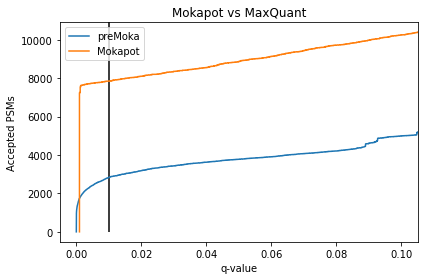

In [12]:
plot_qvalues(mq_cleaned_df["PEP"], label="Pre-mokapot")
plt.title("Mokapot vs MaxQuant")
results.plot_qvalues(label="mokapot")
plt.legend(["preMoka", "Mokapot"])
plt.vlines(x = 0.01, ymin = 0, ymax = 12000)
plt.tight_layout()

plt.show()

In [13]:
print("The number of PSMs found at or above 0.01: ") 
      
print("\t" + "MaxQuant: " + str(len(mq_cleaned_df[mq_cleaned_df['PEP'] <= 0.01])))

print("\t""MaxQuant and MokaPot: " + str(len(results.psms[results.psms['mokapot q-value'] <= 0.01])))

The number of PSMs found at or above 0.01: 
	MaxQuant: 2832
	MaxQuant and MokaPot: 7849
